### This notebook trains proteinVI unshared only on protein to see whether it is able to model protein alone or not

In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
import anndata as ad
import scanpy as sc
import torch
import random

In [2]:
def set_random_seed():
    # Example usage:
    seed = 42
    # Set seed for random module
    random.seed(seed)

    # Set seed for numpy
    np.random.seed(seed)

    # Set seed for torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_random_seed()

In [3]:
# read in RNA data
rna = mmread("./data/citeseq_pbmc/rna.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('./data/citeseq_pbmc/citeseq_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

# read in celltyle labels
metadata = pd.read_csv('./data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

rna_adata.obs['celltype.l1'] = labels_l1
rna_adata.obs['celltype.l2'] = labels_l2

rna_adata_copy = rna_adata.copy()
sc.pp.normalize_total(rna_adata_copy)
sc.pp.log1p(rna_adata_copy)
sc.pp.highly_variable_genes(rna_adata_copy, n_top_genes=4000)
rna_adata = rna_adata[:,rna_adata_copy.var.highly_variable==True]
print("Final stats of rna adata: \n",rna_adata)

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Final stats of rna adata: 
 View of AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'celltype.l1', 'celltype.l2'


In [4]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class ProteinRNADataset(Dataset):
    def __init__(self,rna_adata):
        self.data = np.asarray(rna_adata.X.todense())
        self.labels_l1 = rna_adata.obs['celltype.l1']
        self.labels_l2 = rna_adata.obs['celltype.l2']
        self.local_mean, self.local_var = self.compute_library_size(self.data)
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return {"y":self.data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean, "var": self.local_var}
    
    def compute_library_size(self, data):
        # print(data.shape)
        sum_counts = data.sum(axis=1)
        masked_log_sum = np.ma.log(sum_counts)
        if np.ma.is_masked(masked_log_sum):
            print(
                "Warning: This dataset has some empty cells, this might fail scVI inference. Data should be filtered with `my_dataset.filter_cells_by_count()"
            )
        log_counts = masked_log_sum.filled(0)
        local_mean = (np.mean(log_counts).reshape(-1, 1)).astype(np.float32)
        local_var = (np.var(log_counts).reshape(-1, 1)).astype(np.float32)

        local_mean = torch.Tensor(local_mean).reshape(-1)
        local_var = torch.Tensor(local_var).reshape(-1)
        return local_mean, local_var

dataset = ProteinRNADataset(rna_adata)
train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [7]:
from scvi.models.rna_unshared import RNA_UNSHARED
import torch.nn.functional as F
import torch.optim as optim
model = RNA_UNSHARED(4000, latent_distribution="normal", log_variational=True, reconstruction_loss='zinb')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device used for training is: ", device)
model.to(device)
model_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(model_params, lr=0.001, eps=0.01)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

The device used for training is:  cpu


Epoch: 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.28it/s]


Losses at epoch: 0 is 374490.9091796875---------496.3805282115936--------7526.093887329102


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


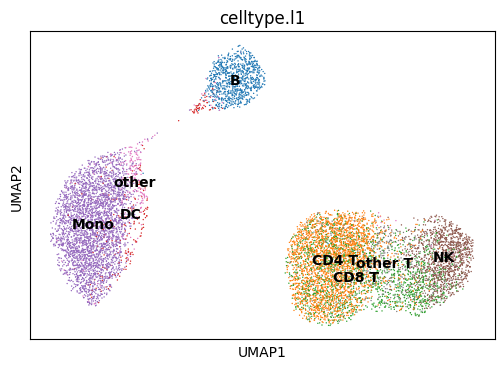

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


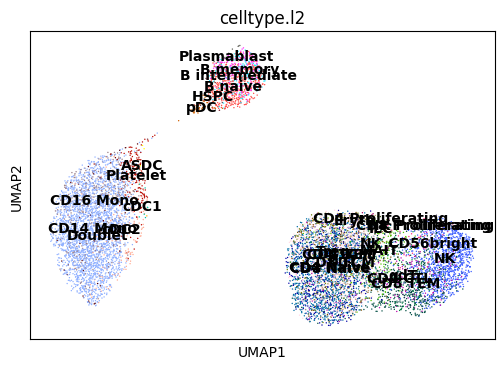

Epoch: 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.35it/s]


Losses at epoch: 20 is 52810.11291503906---------656.5356712341309--------121.4443085193634


Epoch: 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.09it/s]


Losses at epoch: 40 is 51551.407470703125---------656.2592620849609--------124.67863273620605


Epoch: 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.85it/s]
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


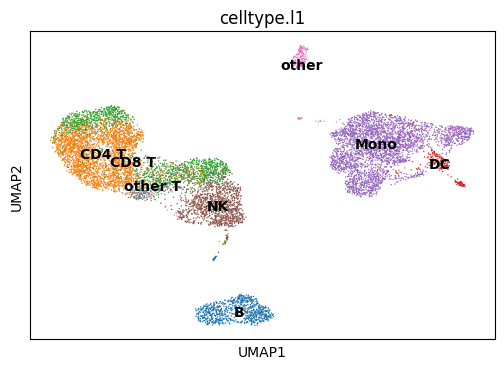

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


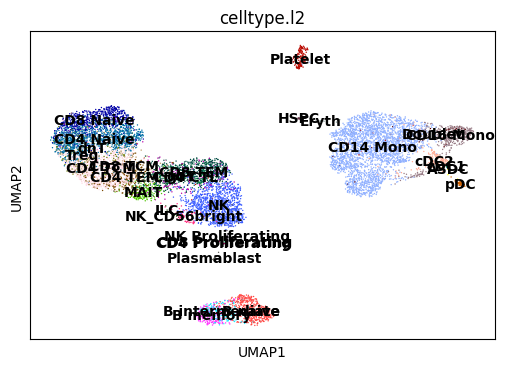

Epoch: 60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.03it/s]


Losses at epoch: 60 is 51062.70861816406---------652.7192277908325--------122.34015774726868


Epoch: 80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.15it/s]


Losses at epoch: 80 is 50328.017822265625---------654.6898155212402--------108.44321656227112


Epoch: 100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.32it/s]


Losses at epoch: 100 is 49889.05993652344---------677.1358089447021--------105.95067119598389


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


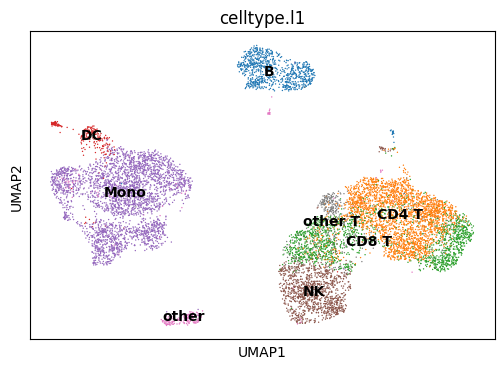

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


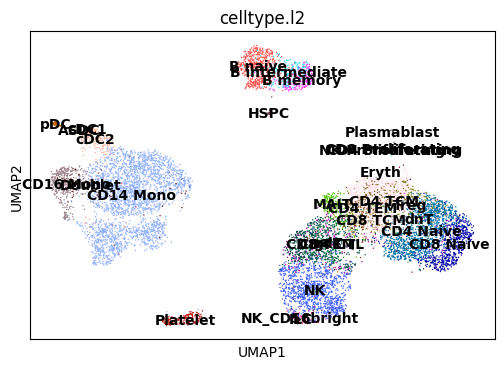

Epoch: 120: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.33it/s]


Losses at epoch: 120 is 49580.54931640625---------685.0843086242676--------109.17068243026733


Epoch: 140: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.41it/s]


Losses at epoch: 140 is 49053.58984375---------694.0653705596924--------98.19953989982605


Epoch: 150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.55it/s]
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


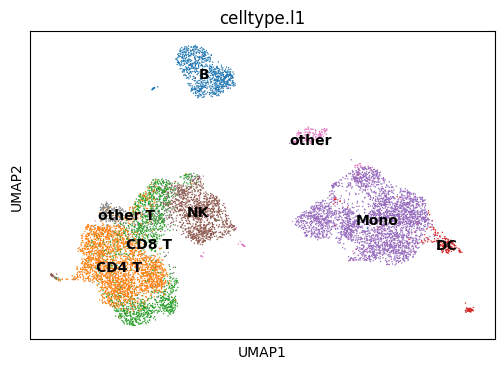

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


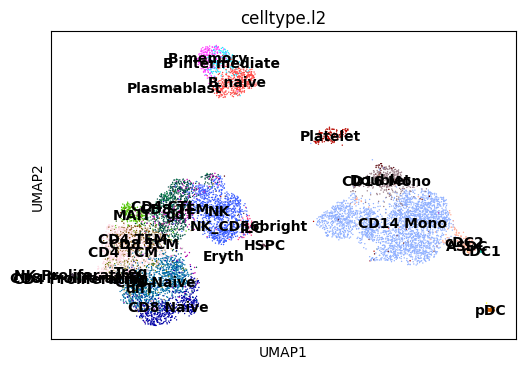

Epoch: 160: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.04it/s]


Losses at epoch: 160 is 48919.84716796875---------707.7948913574219--------95.29291605949402


Epoch: 180: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.36it/s]


Losses at epoch: 180 is 49039.30261230469---------717.8178424835205--------99.72293615341187


Epoch: 200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.75it/s]


Losses at epoch: 200 is 48360.74658203125---------722.3676853179932--------94.88209509849548


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


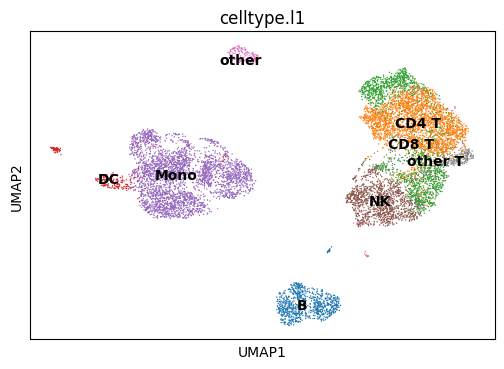

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


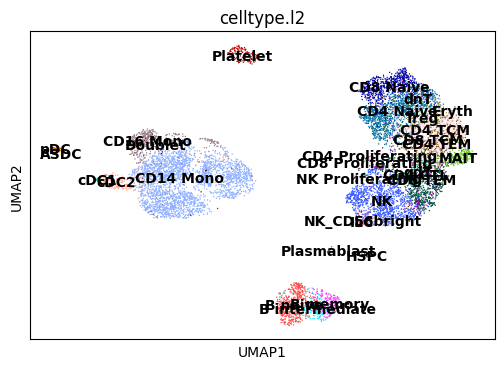

Epoch: 220: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.69it/s]


Losses at epoch: 220 is 48354.1611328125---------733.0177478790283--------99.33887910842896


Epoch: 240: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.75it/s]


Losses at epoch: 240 is 48279.19396972656---------729.9877910614014--------93.1383912563324


Epoch: 250: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.56it/s]
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


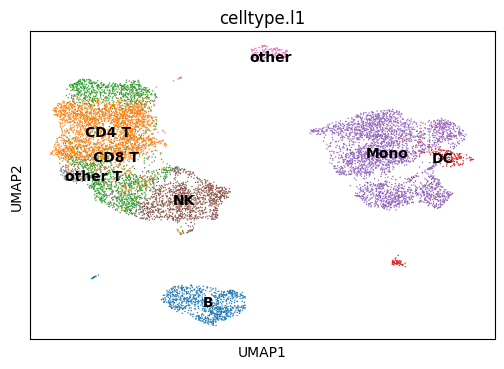

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


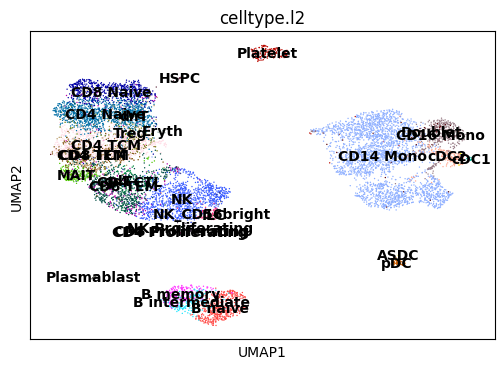

Epoch: 260: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.62it/s]


Losses at epoch: 260 is 48185.58508300781---------737.6505851745605--------96.58848714828491


Epoch: 280: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.69it/s]


Losses at epoch: 280 is 48034.849609375---------747.3514633178711--------88.76193749904633


Epoch: 300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.34it/s]


Losses at epoch: 300 is 47883.90563964844---------739.0554790496826--------91.6061475276947


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


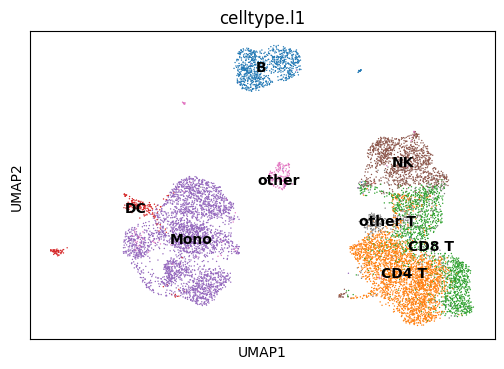

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


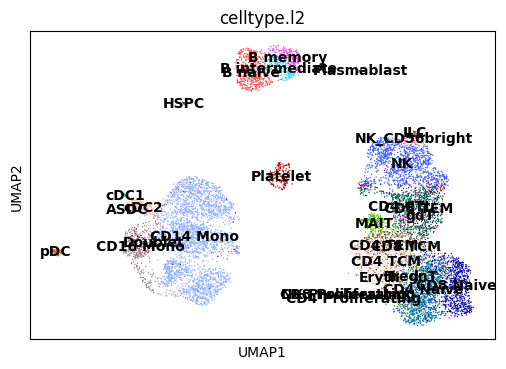

Epoch: 320: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.71it/s]


Losses at epoch: 320 is 47703.42248535156---------742.8981075286865--------91.61755681037903


Epoch: 340: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.74it/s]


Losses at epoch: 340 is 47614.16345214844---------741.71071434021--------90.5629951953888


Epoch: 350: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.56it/s]
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


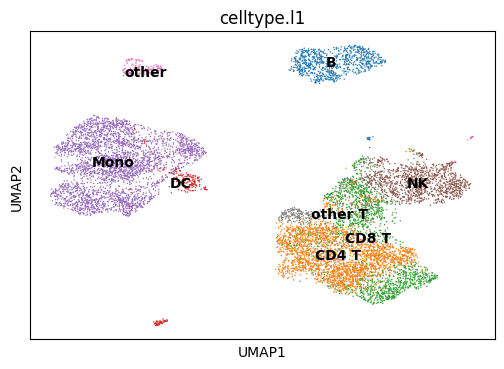

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


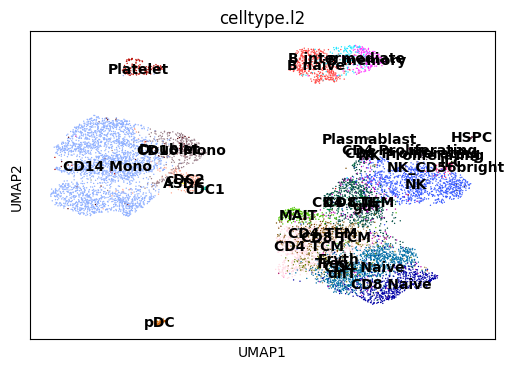

Epoch: 360: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.63it/s]


Losses at epoch: 360 is 47487.26843261719---------743.5277690887451--------89.34102606773376


Epoch: 380: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.63it/s]


Losses at epoch: 380 is 47464.11120605469---------745.5373020172119--------91.03988313674927


Epoch: 400: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.54it/s]


Losses at epoch: 400 is 47403.777587890625---------744.002405166626--------92.27963876724243


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


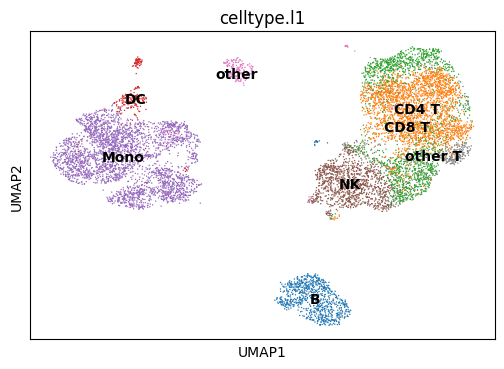

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


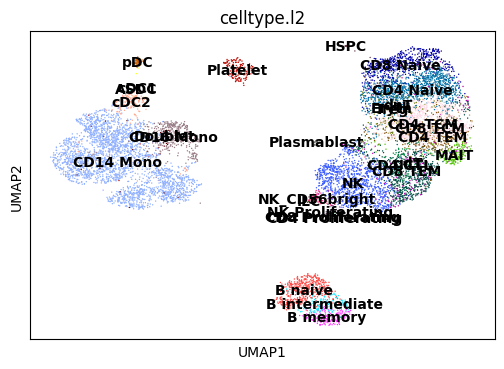

Epoch: 420: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.51it/s]


Losses at epoch: 420 is 47341.590576171875---------734.0735301971436--------89.47170996665955


Epoch: 440: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.41it/s]


Losses at epoch: 440 is 47347.86853027344---------725.6436748504639--------91.69926381111145


Epoch: 450: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.69it/s]
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


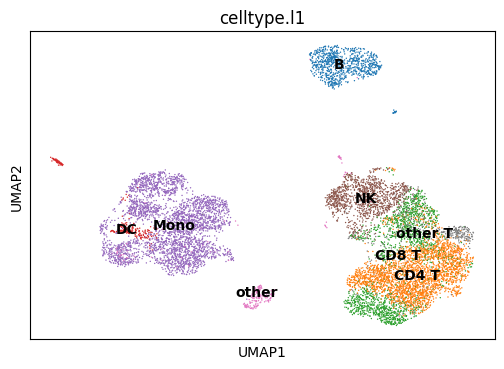

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


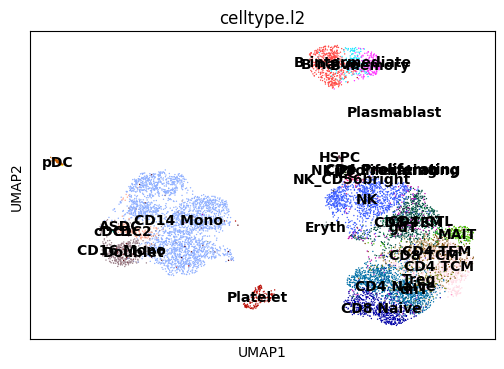

Epoch: 460: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.33it/s]


Losses at epoch: 460 is 47401.44396972656---------714.0998344421387--------90.7356448173523


Epoch: 480: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.52it/s]


Losses at epoch: 480 is 47225.85998535156---------710.2855014801025--------92.36350917816162


Epoch: 499: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.43it/s]


In [8]:
recon_loss_log = []
kl_div_l_log = []
kl_div_z_log = []
kl_weight = 1.0
for epoch in range(500):
    loss = 0.0
    recon_loss_piter = 0.0
    kl_div_l_piter = 0.0
    kl_div_z_piter = 0.0
    for batch in tqdm(train_dataloader, desc="Epoch: {}".format(epoch)):
        y = batch["y"]
        lmean = batch["mean"]
        lvar = batch["var"]
        y = y.to(device)
        lmean = lmean.to(device)
        lvar = lvar.to(device)
        optimizer.zero_grad()
        recon_loss, kl_div_l, kl_div_z, _ = model(y, lmean, lvar)
        loss = torch.mean(recon_loss) + kl_weight*torch.mean(kl_div_z) + torch.mean(kl_div_l)
        loss.backward()
        optimizer.step()
        recon_loss_piter += torch.mean(recon_loss).item()
        kl_div_z_piter += torch.mean(kl_div_z).item()
        kl_div_l_piter += torch.mean(kl_div_l).item()
    recon_loss_log.append(recon_loss_piter/len(train_dataloader))
    kl_div_z_log.append(kl_div_z_piter/len(train_dataloader))
    kl_div_l_log.append(kl_div_l_piter/len(train_dataloader))
    # scheduler.step()
    kl_weight = max(kl_weight,epoch/400)
    if epoch%20==0:
        print("Losses at epoch: {} is {}---------{}--------{}".format(epoch,recon_loss_piter,kl_div_z_piter, kl_div_l_piter))
    if epoch%50==0:
        with torch.no_grad():
            rna_data = torch.Tensor(dataset.data)
            labelsl1 = dataset.labels_l1
            labelsl2 = dataset.labels_l2
            mean_tensor = torch.Tensor(dataset.local_mean.reshape(-1,1).expand(10000, 1)).to(device)
            var_tensor = torch.Tensor(dataset.local_var.reshape(-1,1).expand(10000, 1)).to(device)
            _, _, _, z = model(rna_data, mean_tensor, var_tensor)
            adata_plot = ad.AnnData(X=z.numpy())
            adata_plot.obs['celltype.l1'] = labelsl1
            adata_plot.obs['celltype.l2'] = labelsl2
            sc.pp.neighbors(adata_plot)
            sc.tl.umap(adata_plot)
            sc.pl.umap(adata_plot, color='celltype.l1', legend_loc='on data', s=4)            
            sc.pl.umap(adata_plot, color='celltype.l2', legend_loc='on data', s=4)

# Final Remark: Its working all good